**Keras CNN with FastText Embeddings**

CNNs provide a faster alternative to LSTM models at a comparable performance. They are faster to train and use fewer parameters. CNN models are translation invariant and in application to text make sense when there is no strong dependence on recent past vs distant past of the input sequence. CNNs can learn patterns in word embeddings and given the nature of the dataset (e.g. multiple misspellings, out of vocabulary words), it makes sense to use sub-word information. In this notebook, a simple CNN architecture is used for multi-label classification with the help of FastText word embeddings. Thus, it can be a good addition (diverse and accurate) to your ensemble.

**IMPORTING THE LIBRARIES**

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# CHANGEMENT DES IMPORTS SEULEMENT
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import os, re, csv, math, codecs



sns.set_style("whitegrid")
np.random.seed(0)

# CHANGEMENT DES CHEMINS DES FICHIERS
DATA_PATH = '/content/'
EMBEDDING_DIR = '/content/'

MAX_NB_WORDS = 100000
nltk_tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

# Suppression de la commande qui vérifie le répertoire ./input
# from subprocess import check_output
# print(check_output(["ls", "./input"]).decode("utf8"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Let's load the data and the embeddings...

In [5]:
# Télécharger les embeddings FastText
print("Téléchargement des embeddings FastText...")
!wget -q https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.simple.vec
print("Téléchargement terminé!")

# load embeddings
print('loading word embeddings...')
embeddings_index = {}

# Chemin corrigé pour Colab
f = codecs.open('/content/wiki.simple.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

Téléchargement des embeddings FastText...
Téléchargement terminé!
loading word embeddings...


111052it [00:14, 7618.71it/s]

found 111052 word vectors


**IMPORTING THE FILES**

num train:  159571
num test:  78599


/tmp/ipython-input-2962157447.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')


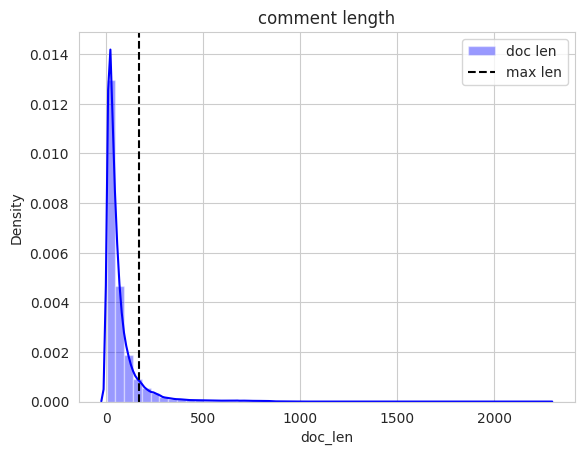

In [6]:
#load data
train_df = pd.read_csv('./train.csv', sep=',')
test_df = pd.read_csv('./test.csv', sep=',')

print("num train: ", train_df.shape[0])
print("num test: ", test_df.shape[0])

label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train_df[label_names].values

#visualize word distribution
train_df['doc_len'] = train_df['comment_text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)
sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

# Text Processing and Tokenization

Let's pre-process the text, tokenize it and pad it to a maximum length (as in the figure above).

In [7]:
raw_docs_train = train_df['comment_text'].tolist()
raw_docs_test = test_df['comment_text'].tolist()
num_classes = len(label_names)

print("pre-processing train data...")
processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = nltk_tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = nltk_tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = pad_sequences(word_seq_test, maxlen=max_seq_len)

pre-processing train data...


100%|██████████| 78599/78599 [00:02<00:00, 27913.02it/s]


tokenizing input data...
dictionary size:  276685


Let's define our training and model parameters:

In [8]:
#training params
batch_size = 256
num_epochs = 8

#model parameters
num_filters = 64
embed_dim = 300
weight_decay = 1e-4

We can now prepare our embedding matrix limiting to a max number of words:

In [9]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 48465


# Define the CNN architecture

We can finally define the CNN architecture

In [10]:
#CNN architecture
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='sigmoid'))  #multi-label (k-hot encoding)

# CORRECTION DE L'OPTIMISEUR ADAM
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

# CONSTRUIRE EXPLICITEMENT LE MODÈLE POUR ÉVITER LES "UNBUILT" LAYERS
model.build(input_shape=(None, max_seq_len))
print("✅ Modèle CNN créé avec succès!")

training CNN ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    30,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,000,000 (114.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 30,000,000 (114.44 MB)

✅ Modèle CNN créé avec succès!


Because of the multi-label loss, we are using k-hot encoding of the output and sigmoid activations. As a result, the loss is binary cross-entropy.

In [11]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

# Train

In [12]:
#model training
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

Epoch 1/8
561/561 - 20s - 36ms/step - accuracy: 0.8382 - loss: 0.0952 - val_accuracy: 0.9940 - val_loss: 0.0659
Epoch 2/8
561/561 - 6s - 10ms/step - accuracy: 0.9782 - loss: 0.0642 - val_accuracy: 0.9940 - val_loss: 0.0617
Epoch 3/8
561/561 - 6s - 10ms/step - accuracy: 0.9900 - loss: 0.0579 - val_accuracy: 0.9940 - val_loss: 0.0596
Epoch 4/8
561/561 - 6s - 10ms/step - accuracy: 0.9932 - loss: 0.0529 - val_accuracy: 0.9940 - val_loss: 0.0578
Epoch 5/8
561/561 - 6s - 10ms/step - accuracy: 0.9931 - loss: 0.0489 - val_accuracy: 0.9940 - val_loss: 0.0570
Epoch 5: early stopping


# Test aned Prediction


Let's make predictions on the test data:

In [13]:
y_test = model.predict(word_seq_test)

2457/2457 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


# Learning Curves

Looking at training and validation loss / accuracy figures below, we can see there is no sign of over-fitting.

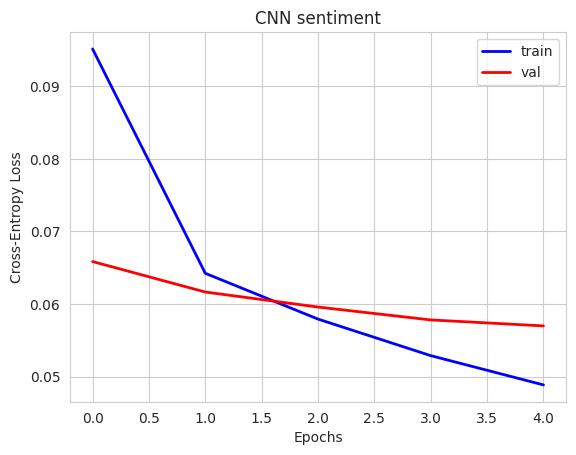

In [14]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

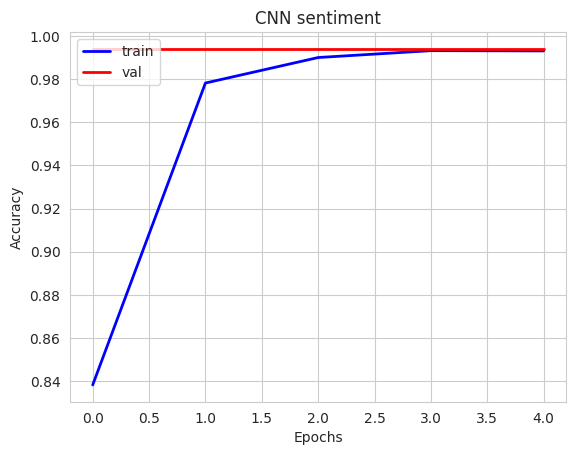

In [15]:
plt.figure()
plt.plot(hist.history['accuracy'], lw=2.0, color='b', label='train')  # 'acc' → 'accuracy'
plt.plot(hist.history['val_accuracy'], lw=2.0, color='r', label='val')  # 'val_acc' → 'val_accuracy'
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Evaluation with ROC-AUC

CALCUL ROC AUC GLOBAL
4987/4987 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC scor

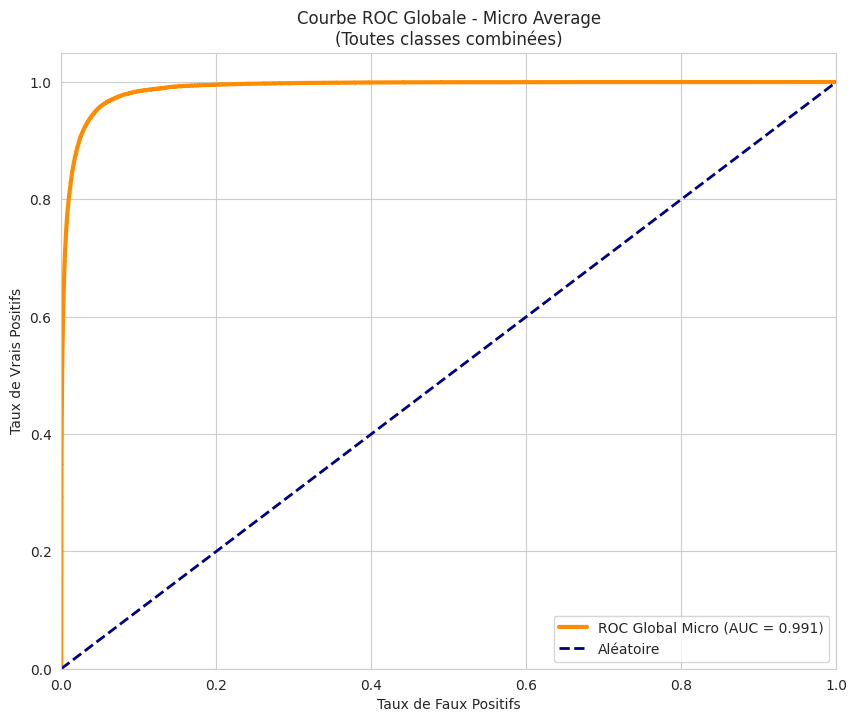

SCORES ROC AUC GLOBAUX:
----------------------------------------
Micro Average  : 0.9905 (toutes prédictions combinées)
Macro Average  : 0.9854 (moyenne des AUC par classe)
Samples Average: nan (performance par commentaire)
----------------------------------------


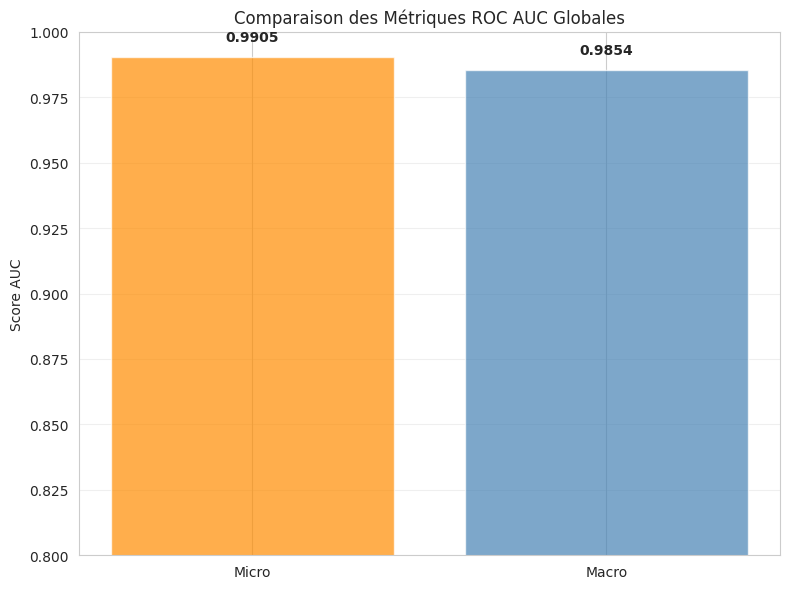

 Analyse ROC AUC globale terminée!


In [16]:
# CALCUL ROC AUC GLOBAL
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

print("CALCUL ROC AUC GLOBAL")
print("=" * 50)

# Prédictions sur l'ensemble d'entraînement
y_train_pred = model.predict(word_seq_train)

# 1. ROC AUC MICRO - TOUTES LES CLASSES COMBINÉES
y_true_flat = y_train.ravel()
y_pred_flat = y_train_pred.ravel()

fpr_micro, tpr_micro, _ = roc_curve(y_true_flat, y_pred_flat)
roc_auc_micro = auc(fpr_micro, tpr_micro)

# 2. ROC AUC MACRO - MOYENNE DES AUC PAR CLASSE
roc_auc_macro = roc_auc_score(y_train, y_train_pred, average='macro')

# 3. ROC AUC SAMPLES - PAR ÉCHANTILLON
roc_auc_samples = roc_auc_score(y_train, y_train_pred, average='samples')

# COURBE ROC GLOBALE (MICRO)
plt.figure(figsize=(10, 8))
plt.plot(fpr_micro, tpr_micro, color='darkorange', lw=3,
         label='ROC Global Micro (AUC = %0.3f)' % roc_auc_micro)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC Globale - Micro Average\n(Toutes classes combinées)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# AFFICHAGE DES SCORES GLOBAUX
print("SCORES ROC AUC GLOBAUX:")
print("-" * 40)
print(f"Micro Average  : {roc_auc_micro:.4f} (toutes prédictions combinées)")
print(f"Macro Average  : {roc_auc_macro:.4f} (moyenne des AUC par classe)")
print(f"Samples Average: {roc_auc_samples:.4f} (performance par commentaire)")
print("-" * 40)

# COMPARAISON VISUELLE DES MÉTRIQUES GLOBALES
plt.figure(figsize=(8, 6))
metrics = ['Micro', 'Macro', 'Samples']
scores = [roc_auc_micro, roc_auc_macro, roc_auc_samples]
colors = ['darkorange', 'steelblue', 'forestgreen']

bars = plt.bar(metrics, scores, color=colors, alpha=0.7)
plt.ylim(0.8, 1.0)
plt.ylabel('Score AUC')
plt.title('Comparaison des Métriques ROC AUC Globales')
plt.grid(True, axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(" Analyse ROC AUC globale terminée!")

# Exporter Le Model

In [17]:
model.save("cnn_model.h5")


# Exporter Toknizer

In [18]:
"""
Script à ajouter à la fin de votre notebook CNN pour sauvegarder le tokenizer
Exécutez ce code dans votre notebook CNN après l'entraînement du modèle
"""

import pickle
import os

# Créer le dossier si nécessaire
os.makedirs('./models/cnn', exist_ok=True)

# Sauvegarder le tokenizer (la variable 'tokenizer' existe déjà dans votre notebook)
with open('./models/cnn/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print(" Tokenizer CNN sauvegardé dans ./models/cnn/tokenizer.pkl")

# Télécharger le fichier (pour Google Colab)
from google.colab import files
files.download('./models/cnn/tokenizer.pkl')

print(" Fichier tokenizer.pkl téléchargé. Placez-le dans models/cnn/ de votre application.")

 Tokenizer CNN sauvegardé dans ./models/cnn/tokenizer.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Fichier tokenizer.pkl téléchargé. Placez-le dans models/cnn/ de votre application.
